In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn import datasets
from sklearn import linear_model
from sklearn.svm import l1_min_c
#from sklearn.linear_model import LinearRegression

import h2o4gpu

## Linear Regression

In [2]:
# y = ax + b

X = np.array([1,2,3,4,5,6,7,8,9,10])
X = X.astype(float)

y = 2*X + 10

X = X[:, np.newaxis]
X = np.hstack([X, np.ones((X.shape[0],1), dtype=X.dtype)])

lm = h2o4gpu.LinearRegression()
lm.fit(X, y)

print('Linear Regression')
print('Predicted:', lm.predict(np.array([[15.0, 1.0], [16.0, 1.0]])))
print('Coefficients:', lm.X)

# sklearn
X = np.array([1,2,3,4,5,6,7,8,9,10])
X = X[:, np.newaxis]
# Values to predict
X_test = np.array([15, 16])
X_test = X_test[:, np.newaxis]

sk_lm = linear_model.LinearRegression()
sk_lm.fit(X, np.transpose(y))

print('------------')
print('scikit-learn')
print('Predicted:', sk_lm.predict(X_test))
print('Coefficients:', sk_lm.coef_)

Linear Regression
Predicted: [[ 39.93816196  41.93188356]]
Coefficients: [[  1.9937216   10.03233797]]
------------
scikit-learn
Predicted: [ 40.  42.]
Coefficients: [ 2.]


## Logistic Regression

### Data Prep

In [3]:
iris = datasets.load_iris()

X = iris.data
y = iris.target

dfX = pd.DataFrame(X)
dfy = pd.DataFrame(y)

dfy.loc[:,0].value_counts()

2    50
1    50
0    50
Name: 0, dtype: int64

In [4]:
# making it a binary problem
# removing third class
X = X[y != 2]
y = y[y != 2]

# subtracting the mean
X -= np.mean(X, 0)

In [5]:
X_test = X[np.r_[40:50,90:100]]
y_test = y[np.r_[40:50,90:100]]
X = X[np.r_[:40,50:90]]
y = y[np.r_[:40,50:90]]

### sklearn logistic regression

In [6]:
cs = l1_min_c(X, y, loss='log') * np.logspace(0, 3)

In [7]:
start = time.time()
clf = linear_model.LogisticRegression(C = 1.0, penalty = 'l1'
                         #, tol=1e-6
                        )
coefs_ = []
for c in cs:
    clf.set_params(C=c)
    clf.fit(X, y)
    coefs_.append(clf.coef_.ravel().copy())
print(time.time() - start)

0.05513119697570801


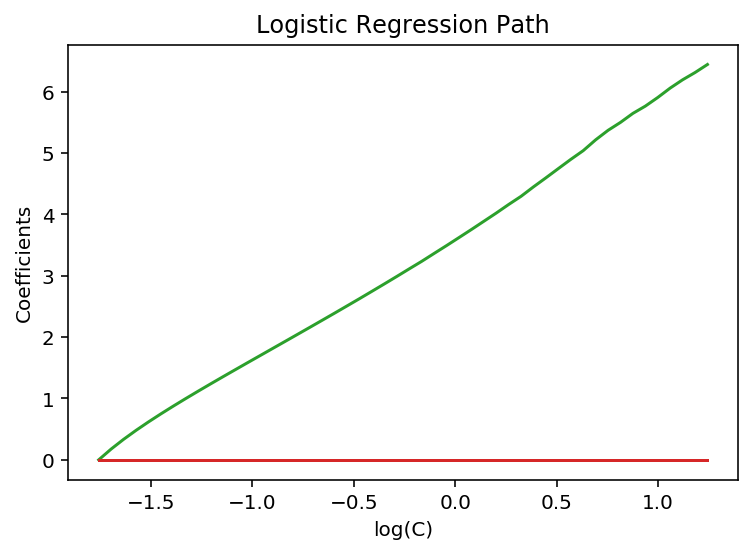

(50, 4)


In [8]:
coefs_ = np.array(coefs_)
plt.plot(np.log10(cs), coefs_)
ymin, ymax = plt.ylim()
plt.xlabel('log(C)')
plt.ylabel('Coefficients')
plt.title('Logistic Regression Path')
plt.axis('tight')
plt.show()
print(coefs_.shape)

In [9]:
y_pred = clf.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
clf.predict_proba(X_test)

array([[  9.99932222e-01,   6.77780147e-05],
       [  9.99932222e-01,   6.77780147e-05],
       [  9.99932222e-01,   6.77780147e-05],
       [  9.99531863e-01,   4.68136891e-04],
       [  9.96774248e-01,   3.22575200e-03],
       [  9.99870913e-01,   1.29086709e-04],
       [  9.99531863e-01,   4.68136891e-04],
       [  9.99870913e-01,   1.29086709e-04],
       [  9.99754161e-01,   2.45838631e-04],
       [  9.99870913e-01,   1.29086709e-04],
       [  3.12226255e-05,   9.99968777e-01],
       [  8.60677825e-06,   9.99991393e-01],
       [  4.10754010e-04,   9.99589246e-01],
       [  3.60215791e-02,   9.63978421e-01],
       [  1.13258920e-04,   9.99886741e-01],
       [  1.13258920e-04,   9.99886741e-01],
       [  1.13258920e-04,   9.99886741e-01],
       [  5.94670599e-05,   9.99940533e-01],
       [  2.05212724e-01,   7.94787276e-01],
       [  2.15698555e-04,   9.99784301e-01]])

### H2O4GPU

In [11]:
classification = True

In [12]:
logreg = h2o4gpu.LogisticRegression(alpha_max = 1.0
                                    , alpha_min = 1.0
                                   )

In [13]:
start = time.time()
model = logreg.fit(X, y)
print(time.time() - start)
model

0.9965429306030273


In [14]:
y_pred_h2o = model.predict(X_test)
y_pred_h2o

array([[ 0.5163793 ,  0.5907447 ,  0.58417682,  0.55988864,  0.50492926,
         0.54436646,  0.47789073,  0.55462687,  0.45261082,  0.49840083,
         0.53462668,  0.47810279,  0.50125192,  0.59493801,  0.54116415,
         0.50917303,  0.52633727,  0.45435158,  0.602883  ,  0.52891951]])

In [15]:
print("Xvsalpha")
print(logreg.x_vs_alphapure)
print(model.x_vs_alphapure)

print("np.shape(Xvsalpha)")
print(np.shape(logreg.x_vs_alphapure))
print(np.shape(model.x_vs_alphapure))

error_train = logreg.error_vs_alpha
if classification:
    print("logloss_train")
else:
    print("rmse_train")
print(error_train)

error_train = model.error_vs_alpha
if classification:
    print("logloss_train")
else:
    print("rmse_train")
print(error_train)

print("Best lambdas")
lambdas = logreg.lambdas_best
print(lambdas)
print(model.lambdas_best)

print("Best alphas")
alphas = logreg.alphas_best
print(alphas)
print(model.alphas_best)

print("Best tols")
tols = logreg.tols_best
print(tols)
print(model.tols_best)

Xvsalpha
[[-0.5599661  -0.01793422 -0.08567183  0.66957007]]
[[-0.5599661  -0.01793422 -0.08567183  0.66957007]]
np.shape(Xvsalpha)
(1, 4)
(1, 4)
logloss_train
[[ 0.68617965 -1.         -1.        ]]
logloss_train
[[ 0.68617965 -1.         -1.        ]]
Best lambdas
[[  1.48219694e-323]]
[[  1.48219694e-323]]
Best alphas
[[ 1.]]
[[ 1.]]
Best tols
[[ 0.01]]
[[ 0.01]]


In [16]:
logreg.x_vs_alphapure

array([[-0.5599661 , -0.01793422, -0.08567183,  0.66957007]])

In [17]:
model.X_full

AttributeError: 'LogisticRegression' object has no attribute 'x_vs_alpha_lambdapure'

In [18]:
model.X_best

array([[-0.5599661 , -0.01793422, -0.08567183,  0.66957007]])

In [19]:
logreg = h2o4gpu.LogisticRegression(alpha_max = 1.0, 
                                    alpha_min = 1.0,
                                    give_full_path = 1,
                                    n_lambdas = 50,
                                    glm_stop_early = False
                                   )
start = time.time()
logreg.fit(X, y)
print(time.time() - start)
logreg.lambdas_full

136.42706084251404


array([[[  3.06320700e-322]],

       [[  2.22329541e-322]],

       [[  1.58101007e-322]],

       [[  1.13635099e-322]],

       [[  8.39911598e-323]],

       [[  5.92878775e-323]],

       [[  4.44659081e-323]],

       [[  2.96439388e-323]],

       [[  1.97626258e-323]],

       [[  1.48219694e-323]],

       [[  9.88131292e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [[  4.94065646e-324]],

       [

#### 136 seconds for 80 x 4  training_frame seems excessive

In [20]:
y_pred_h2o

array([[ 0.5163793 ,  0.5907447 ,  0.58417682,  0.55988864,  0.50492926,
         0.54436646,  0.47789073,  0.55462687,  0.45261082,  0.49840083,
         0.53462668,  0.47810279,  0.50125192,  0.59493801,  0.54116415,
         0.50917303,  0.52633727,  0.45435158,  0.602883  ,  0.52891951]])

In [25]:
logreg_path = h2o4gpu.GLM(family='logistic', verbose=100)
logreg_path.fit(X, y)

Using GPU GLM solver with 2 GPUs
no data
no data
no data
Correct train inputs
Detected np.float64 data
Detected np.float64
double precision fit


In [26]:
logreg_path.predict(X_test)

no data
no data
no data
no data
no data
no data
Correct prediction inputs
Detected np.float64 data
Detected np.float64
double precision fit
thecount=20 count_full_value=0 count_short_value=10 n=4 NUMALLOTHER=6 m_valid=20


array([[ 0.5163793 ,  0.5907447 ,  0.58417682,  0.55988864,  0.50492926,
         0.54436646,  0.47789073,  0.55462687,  0.45261082,  0.49840083,
         0.53462668,  0.47810279,  0.50125192,  0.59493801,  0.54116415,
         0.50917303,  0.52633727,  0.45435158,  0.602883  ,  0.52891951]])

### H2O3 Logistic Regression

In [27]:
import h2o
from h2o.estimators import H2OGeneralizedLinearEstimator 

In [28]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_131"; Java(TM) SE Runtime Environment (build 1.8.0_131-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.131-b11, mixed mode)
  Starting server from /home/karen/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp6_q4vq_e
  JVM stdout: /tmp/tmp6_q4vq_e/h2o_karen_started_from_python.out
  JVM stderr: /tmp/tmp6_q4vq_e/h2o_karen_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster version:,3.10.4.8
H2O cluster version age:,3 months and 8 days
H2O cluster name:,H2O_from_python_karen_yko529
H2O cluster total nodes:,1
H2O cluster free memory:,22.70 Gb
H2O cluster total cores:,40
H2O cluster allowed cores:,40
H2O cluster status:,"accepting new members, healthy"
H2O connection url:,http://127.0.0.1:54321
H2O connection proxy:,None


In [29]:
hf_X = h2o.H2OFrame(X)
hf_y = h2o.H2OFrame(y)
hf_X_test = h2o.H2OFrame(X_test)
hf_y_test = h2o.H2OFrame(y_test)
hf_y = hf_y.asfactor()
hf_y_test = hf_y_test.asfactor()
hf = hf_X.cbind(hf_y)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [30]:
h2olr = H2OGeneralizedLinearEstimator(family = 'binomial')
start = time.time()
h2olr.train(x=['C1','C2', 'C3', 'C4'] ,y='C10', training_frame=hf)
print(time.time()- start)

glm Model Build progress: |███████████████████████████████████████████████| 100%
0.44748449325561523


In [31]:
hf_predict = h2olr.predict(hf_X_test)

glm prediction progress: |████████████████████████████████████████████████| 100%


In [32]:
hf_predict.head(10)

predict,p0,p1
0,0.99894,0.00105951
0,0.945188,0.054812
0,0.99902,0.000979667
0,0.993391,0.00660907
0,0.998349,0.0016513
0,0.993288,0.00671188
0,0.999591,0.000408773
0,0.998476,0.00152446
0,0.999336,0.000664274
0,0.99823,0.00176956


In [33]:
hf_predict.tail(10)

predict,p0,p1
1,0.00129041,0.99871
1,0.000803543,0.999196
1,0.00172183,0.998278
1,0.0125786,0.987421
1,0.00151788,0.998482
1,0.00658678,0.993413
1,0.00288749,0.997113
1,0.00124,0.99876
0,0.025639,0.974361
1,0.0023271,0.997673


In [34]:
h2o.cluster().shutdown()

H2O session _sid_b969 closed.
